# Building an Image Classifier with Pytotrch


In [ ]:
import torch
import torchvision
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
import torch.nn as nn
from torchmetrics import Accuracy

In [86]:
import sys
import subprocess
import importlib.util

package_name = 'torchmetrics'

if importlib.util.find_spec(package_name) is None:
    print(f"Installing {package_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
else:
    print(f"{package_name} is already installed. Skipping.")

torchmetrics is already installed. Skipping.


In [120]:
import sys
import subprocess
import importlib.util

package_name = 'torchinfo'

if importlib.util.find_spec(package_name) is None:
    print(f"Installing {package_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
else:
    print(f"{package_name} is already installed. Skipping.")

Installing torchinfo...


In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [88]:
toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

In [89]:
train_valid_data = torchvision.datasets.FashionMNIST(
    root='datasets', train=True, download=True,
    transform = toTensor
)

In [90]:
test_data = torchvision.datasets.FashionMNIST(
    root='datasets', train=False, download=True, transform=toTensor
)

In [91]:
train_data, valid_data = torch.utils.data.random_split(train_valid_data, [55000, 5000])

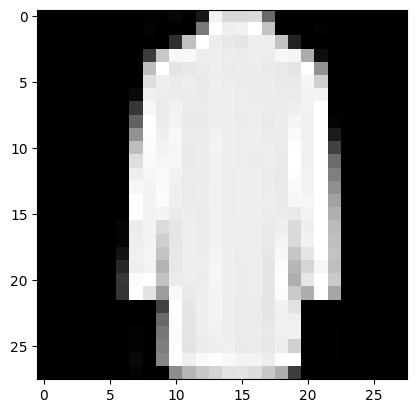

In [92]:
random_index = torch.randint(len(train_data), size=(1,)).item()
plt.imshow(train_data[random_index][0].squeeze(), cmap='gray')
plt.show()

In [93]:
from torch.utils.data import DataLoader

In [94]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)
valid_loader = DataLoader(valid_data, batch_size=32)

In [95]:
X_sample, y_sample = train_data[0]

In [96]:
X_sample.shape

torch.Size([1, 28, 28])

In [97]:
y_sample

2

In [98]:
train_valid_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [126]:
class ImageClassifier(nn.Module):

    def __init__(self, n_inputs, n_hidden_1, n_hidden_2):

        super().__init__()
        self.ann = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=n_inputs, out_features=n_hidden_1), nn.ReLU(),
            nn.Linear(in_features=n_hidden_1, out_features=n_hidden_2), nn.ReLU(),
            
            nn.Linear(in_features=n_hidden_2, out_features=10)
        )

    def forward(self, X):
        return self.ann(X)

In [100]:
model = ImageClassifier(n_inputs=28*28).to(device)

In [101]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [102]:
model

ImageClassifier(
  (ann): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [103]:
epochs=10

In [104]:
for epoch in range(epochs):
    # training mode    
    model.train()

    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        
        # clear gradients
        optimizer.zero_grad()

        # moving data batches to gpu
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # forward pass
        y_pred = model(X_batch)

        # loss calculate 
        loss = loss_function(y_pred, y_batch)

        # total loss
        total_loss+=loss.item()

        # backward pass
        loss.backward()

        # gradients update
        optimizer.step()

    mean_loss = total_loss / len(train_loader)

    print(f"Epoch: {epoch+1}/{epochs}, Loss:{mean_loss:.4f}")

        

Epoch: 1/10, Loss:0.5089
Epoch: 2/10, Loss:0.3707
Epoch: 3/10, Loss:0.3322
Epoch: 4/10, Loss:0.3075
Epoch: 5/10, Loss:0.2910
Epoch: 6/10, Loss:0.2735
Epoch: 7/10, Loss:0.2603
Epoch: 8/10, Loss:0.2508
Epoch: 9/10, Loss:0.2376
Epoch: 10/10, Loss:0.2274


In [106]:
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [107]:
model.eval()

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        accuracy.update(y_pred, y_batch)

In [108]:
avg_accuracy = accuracy.compute()
print(f"Validation Accuracy: {avg_accuracy*100:.2f}%")

Validation Accuracy: 89.14%


In [109]:
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

model.eval()

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        accuracy.update(y_pred, y_batch)

avg_accuracy = accuracy.compute()
print(f"Average Accuracy : {avg_accuracy*100:.2f}%")

Average Accuracy : 92.04%


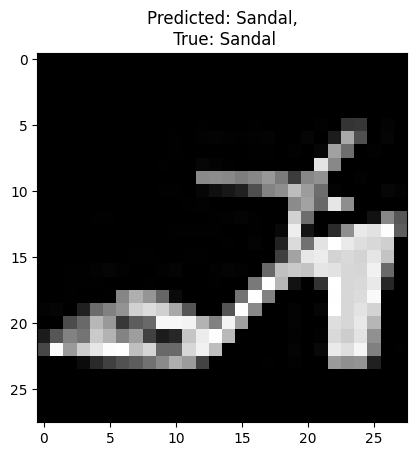

Predicted Class : 5
True Class : 5


In [110]:
# prediction on a random sample from the validation set
model.eval()
random_index = torch.randint(len(valid_data), size=(1,)).item()
X_sample, y_true = valid_data[random_index]

with torch.no_grad():
    X_sample = X_sample.unsqueeze(0).to(device)
    y_pred = model(X_sample)
    prediction = torch.argmax(y_pred, dim=1).item()

plt.title(f'Predicted: {train_valid_data.classes[prediction]},\n True: {train_valid_data.classes[y_true]}')
plt.imshow(X_sample.cpu().squeeze(), cmap='gray')
plt.show()
print(f"Predicted Class : {prediction}")
print(f"True Class : {y_true}")

In [111]:
# get probabilities
probabs = torch.softmax(y_pred, dim=1)
top_3_probabs, top_3_indices = torch.topk(probabs, k=3, dim=1)

In [112]:
top_3_probabs, top_3_indices

(tensor([[1.0000e+00, 3.3844e-15, 1.3503e-16]], device='cuda:0'),
 tensor([[5, 0, 4]], device='cuda:0'))

In [113]:
top_3_probabs = top_3_probabs.squeeze()

In [114]:
top_3_probabs[0].item(), top_3_probabs[1].item(), top_3_probabs[2].item()

(1.0, 3.3844408429495407e-15, 1.3502947935385847e-16)

In [115]:
top_3_indices = top_3_indices.squeeze()
top_3_indices[0].item(), top_3_indices[1].item(), top_3_indices[2].item()

(5, 0, 4)

In [116]:
torch.save(model.state_dict(), 'model.pth')

In [122]:
from torchinfo import summary
summary(model, input_size=( 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 300]                  235,500
│    └─ReLU: 2-3                         [1, 300]                  --
│    └─Linear: 2-4                       [1, 100]                  30,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.07
Estimated Total Size (MB): 1.07

In [123]:
import sys
import subprocess
import importlib.util

package_name = 'optuna'

if importlib.util.find_spec(package_name) is None:
    print(f"Installing {package_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
else:
    print(f"{package_name} is already installed. Skipping.")

Installing optuna...


In [125]:
import optuna
import torch.optim as optim

In [127]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    
    n_hidden = trial.suggest_int("n_hidden", 20, 300)
    
    model = ImageClassifier(n_inputs=28*28, n_hidden_1=n_hidden, n_hidden_2=n_hidden).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    epochs = trial.suggest_int("epochs", 5, 30)

    for epoch in range(epochs):

        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)

            loss = loss_function(y_pred, y_batch)

            loss.backward()

            optimizer.step()

    with torch.no_grad():

        model.eval()
        
        accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

        for X_batch, y_batch in valid_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)

            accuracy.update(y_pred, y_batch)

        avg_accuracy = accuracy.compute()
        
    return avg_accuracy.item()

In [128]:
device

device(type='cuda')

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=5)

[I 2026-01-28 19:58:55,342] A new study created in memory with name: no-name-4a4215b3-227c-4351-8d61-b4c2569118b8


In [ ]:
study.best_params

In [ ]:
study.best_value